# Latent_space_visual.ipynb

- This notebook reproduces the following latent-space-related figures in Guo et al. (2025).
    - Fig. 3
    - Fig. 4(a)(b)
    - Fig. 7(a)–(c)
    - Supplementary figures S2, 3, 6, and 10
- **Additional data reminder**:
    - Composite data for IVT regimes have been presaved in `/data/processed/demo_data`, so figures in this notebook can be reproduced without additional datasets.
    - If desired, code in Cell `Regime Processing` can be used to create the composite data, which requires:
        - ERA5 IVT (2001–2019): calculate with `/src/main/data_processing/cal_ERA5_IVT.py`, with U, V, Q  downloaded from (https://cds.climate.copernicus.eu/datasets/derived-era5-single-levels-daily-statistics?tab=download)
        - TaiESM1 IVT (historical and ssp585): to be downloaded from Zenodo (doi:10.5281/zenodo.17199183)
- Execution order of cell sections for reproducing figures: 
    1. `Import`
    2. `Utilities`
    3. Each `Figure: ...`

# Import

In [1]:
import numpy as np
import pandas as pd
import xarray as xr

In [2]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as patches
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmaps
import seaborn.colors.xkcd_rgb as c
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
from cmcrameri import cm as scicmap      # scientific color map

# Utilities

## Data

In [26]:
# For all samples (3477 days)
wtab_all   = pd.read_csv(f"../../data/processed/weather_table_self/all_withlv.csv")       # weather table
swpcp_all  = pd.read_csv(f"../../data/processed/weather_table_self/swland_pcp_all.csv")   # southwestern Taiwan rainfall
twpcp_all  = pd.read_csv(f"../../data/processed/weather_table_self/taiwan_pcp_all.csv")   # Taiwan rainfall
# For testing samples (977 days)
wtab_test  = pd.read_csv(f"../../data/processed/weather_table_self/test_withlv.csv")

In [5]:
# latent vectors for TaiESM1
lv_dict_taiesm = np.load('../../data/processed/fix_latent_vectors/V2_sum_lv_era5_taiesm.npy', allow_pickle=True).item()

In [6]:
# VAE-reconstruction from mid-points of the latent space
recon_dict = np.load('../../data/processed/sample_recon_dict/sum_ver_531135.npy', allow_pickle=True).item()

## General classes and functions

### Plot tools

In [7]:
class PlotTools_cartopy():
    def __init__(self):
        self.proj = ccrs.PlateCarree()
    
    def Axe_map(self, fig, gs, 
                xlim_, ylim_, **grid_info):
        # Set map extent
        axe  = fig.add_subplot(gs, projection=self.proj)
        axe.set_extent([xlim_[0], xlim_[-1], ylim_[0], ylim_[-1]], crs=self.proj)
        # Set additional grid information
        if len(grid_info)>0:
            if grid_info['xloc_'] is not None:
                axe.set_xticks(grid_info['xloc_'], crs=self.proj)
                axe.set_xticklabels(['' for i in range(len(grid_info['xloc_']))])  # default: no tick labels
            if grid_info['yloc_'] is not None:
                axe.set_yticks(grid_info['yloc_'], crs=self.proj)
                axe.set_yticklabels(['' for i in range(len(grid_info['yloc_']))])
            gl = axe.gridlines(xlocs=grid_info['xloc_'], ylocs=grid_info['yloc_'], 
                               draw_labels=False)
        return axe
    
    def Plot_cartopy_map(self, axe):
        axe.add_feature(cfeature.LAND,color='grey',alpha=0.1)
        axe.coastlines(resolution='50m', color='black', linewidth=1)
    
plottools_ctpy = PlotTools_cartopy()

In [8]:
def Plot_scatter(axe, x_, y_, c_=None, color_=None, 
                 s_=None, alpha_=None, label_=None, 
                 cmap_=None, bounds_=None, norm_=None, extend_='neither'):
    """
    Create scatter plot with some personal settings.
    """
    if bounds_ is not None:
        norm_    = colors.BoundaryNorm(bounds_, cmap_.N, extend=extend_)
    im = axe.scatter(x_, y_, c=c_, color=color_, s=s_, alpha=alpha_, 
                     label=label_, cmap=cmap_, norm=norm_)
    return im

### Other functions

In [9]:
def draw_cat_bound(axe):
    axe.hlines(y=2, xmin=-6, xmax=-3.93, linewidths=3.5, colors='k')
    axe.hlines(y=0, xmin=-4.08, xmax=6, linewidths=3.5, colors='k')
    axe.vlines(x=-4, ymin=-0.08, ymax=2.08, linewidths=3.5, colors='k')
    axe.vlines(x=-2, ymin=-6, ymax=0, linewidths=3.5, colors='k')

In [10]:
def extract_cat_indices(cat_bounds:dict, latent_vectors_0:np.ndarray, latent_vectors_1:np.ndarray):
    # Empty indices dict
    cat_indices = {cat: [] for cat in cat_bounds}
    for cat_num in cat_bounds.keys():
        # Extract boundary values
        x1_min, x1_max = cat_bounds[cat_num]['x1']
        y1_min, y1_max = cat_bounds[cat_num]['y1']
        x2_min, x2_max = cat_bounds[cat_num]['x2']
        y2_min, y2_max = cat_bounds[cat_num]['y2']
        # Boolean masks
        mask_x1 = (latent_vectors_0 >= x1_min) & (latent_vectors_0 < x1_max)
        mask_y1 = (latent_vectors_1 >= y1_min) & (latent_vectors_1 < y1_max)
        mask_x2 = (latent_vectors_0 >= x2_min) & (latent_vectors_0 < x2_max)
        mask_y2 = (latent_vectors_1 >= y2_min) & (latent_vectors_1 < y2_max)
        # Combine masks
        final_mask = (mask_x1 & mask_y1) | (mask_x2 & mask_y2)
        # Save indices
        cat_indices[cat_num] = np.where(final_mask)[0]
    return cat_indices

## Figure info. settings

In [11]:
# Regime annotation
sum_rgime_list    = ['N4', 'C6',  'B8',  'B9',  'B10', 'B11', 
                     'C4', 'C5',  'B4',  'B5',  'B6',  'B7', 
                     'C2', 'C3',  'B1',  'B2',  'B3',  'N3', 
                     'C1', 'A12', 'A13', 'A14', 'A15', 'N2', 
                     'A6', 'A7',  'A8',  'A9',  'A10', 'A11',
                     'A1', 'A2',  'A3',  'A4',  'A5',  'N1']

In [12]:
# Delineate categorical space in coordination
cat1_bound = {'x1':(-6, -4), 'y1':(2, 6), 'x2':(-4, 6), 'y2':(0, 6)}
cat2_bound = {'x1':(-2, 0), 'y1':(-6, 0), 'x2':(0, 6), 'y2':(-6, 0)}
cat3_bound = {'x1':(-4, -2), 'y1':(-6, 0), 'x2':(-6, -4), 'y2':(-6, 2)}
sum_cat_bounds = {'cat1':cat1_bound, 'cat2':cat2_bound, 'cat3':cat3_bound}

# Figure: Latent Sp

### Fig. 3a

In [13]:
def Plot_LS_plain(data_label:str):
    wtab_used  = eval(f'wtab_{data_label}')
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.grid(linewidth=0.5, linestyle=':', color=c['grey'])
    ax.scatter(wtab_used[f'ERA5_{data_label}_lv0'], wtab_used[f'ERA5_{data_label}_lv1'], s=120, color='k', alpha=0.6, zorder=10)  # changed from s=150
    rect = patches.Rectangle((-6, -6), 12, 12, fc="none", ec=c['charcoal grey'], linewidth=2.5, zorder=5, label='Analyzed samples (more than 99.5 %)')
    ax.add_artist(rect)
    ax.legend(handles=[rect], fontsize=13)
    ax.set_xlim(-8, 8)
    ax.set_xticks(np.arange(-8, 8.1, 2))
    ax.set_xticklabels([f'{int(ii)}' for ii in np.arange(-8, 8.1, 2)], fontsize=14)
    ax.set_ylim(-8, 8)
    ax.set_yticks(np.arange(-8, 8.1, 2))
    ax.set_yticklabels([f'{int(ii)}' for ii in np.arange(-8, 8.1, 2)], fontsize=14)
    ax.set_xlabel('Latent Dim. 0', fontsize=14)
    ax.set_ylabel('Latent Dim. 1', fontsize=14)
    ax.set_aspect('equal', 'box')
    ax.set_title(f'(a) Original Embedding', loc='left', fontsize=16)
    plt.show()

In [14]:
Plot_LS_plain(data_label='all')

### Fig. 3b

In [15]:
def Plot_LS_reg(data_label:str, cat_color:bool):
    """
    Plot the latent space with (1) regime annotation and (2) category boundaries.
    Optional: Denote different categories with color and colorbar.
    """
    wtab_used  = eval(f'wtab_{data_label}')
    # Figure
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.grid(linewidth=1.2, linestyle=':', color='k')
    draw_cat_bound(ax)
    ## Regime annotation
    rcounter:int = 0
    for i in np.arange(-5, 5.1, 2):
        for j in np.arange(-5, 5.1, 2):
            if sum_rgime_list[rcounter][0] == 'N':
                ax.text(j, i, sum_rgime_list[rcounter], fontsize=14, fontweight='bold',
                        horizontalalignment='center', verticalalignment='center', color=c['silver'])
            else:
                ax.text(j, i, sum_rgime_list[rcounter], fontsize=14, fontweight='bold',
                    horizontalalignment='center', verticalalignment='center')
            rcounter+= 1
    ## Scatter dot color
    if cat_color:
        cat_indices = extract_cat_indices(cat_bounds=sum_cat_bounds, 
                                          latent_vectors_0=wtab_used[f'ERA5_{data_label}_lv0'].to_numpy(), 
                                          latent_vectors_1=wtab_used[f'ERA5_{data_label}_lv1'].to_numpy())
        samp_in_cat = [v.shape[0] for v in cat_indices.values()]
        clist = ['#97BACC', '#DFC478', '#CC8E56']
        for draw_cat in range(len(cat_indices.keys())):
            Plot_scatter(axe=ax, 
                     x_=wtab_used[f'ERA5_{data_label}_lv0'].iloc[cat_indices[f'cat{draw_cat+1}']], 
                     y_=wtab_used[f'ERA5_{data_label}_lv1'].iloc[cat_indices[f'cat{draw_cat+1}']], 
                     color_=clist[draw_cat], s_=120, alpha_=0.6)
        ## Color bar
        cmap = colors.ListedColormap(clist[:len(cat_indices.keys())])
        bounds = np.array([sum(samp_in_cat[:ii])/sum(samp_in_cat)*1e2 for ii in range(len(cat_indices.keys())+1)])
        norm = colors.BoundaryNorm(bounds, cmap.N)
        cax  = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 0.02, ax.get_position().height])
        cbar = fig.colorbar(cm.ScalarMappable(cmap=cmap, norm=norm), 
                            cax=cax, orientation='vertical',
                            spacing='proportional', drawedges=True)
        category_name = ['A', 'B', 'C']
        cbar.set_ticks(ticks=(bounds[:-1]+bounds[1:])/2, labels=[f'Cat. {category_name[ii]}\n({ss/sum(samp_in_cat)*1e2:3.1f} %)' for ii, ss in enumerate(samp_in_cat)])
        cbar.ax.tick_params(labelsize=13)
        cbar.outline.set_linewidth(1.5)
        cbar.ax.invert_yaxis()
    else:
        ax.scatter(wtab_used[f'ERA5_{data_label}_lv0'], wtab_used[f'ERA5_{data_label}_lv1'], s=150, color=c['grey'], alpha=0.6)
    
    ax.set_xlim(-6, 6)
    ax.set_xticks(np.arange(-6, 6.1, 2))
    ax.set_xticklabels([f'{int(ii)}' for ii in np.arange(-6, 6.1, 2)], fontsize=14)
    ax.set_ylim(-6, 6)
    ax.set_yticks(np.arange(-6, 6.1, 2))
    ax.set_yticklabels([f'{int(ii)}' for ii in np.arange(-6, 6.1, 2)], fontsize=14)
    ax.set_xlabel('Latent Dim. 0', fontsize=14)
    ax.set_ylabel('Latent Dim. 1', fontsize=14)
    ax.set_aspect('equal', 'box')
    ax.set_title(f'(b) Regime Classification', loc='left', fontsize=16)
    plt.show()

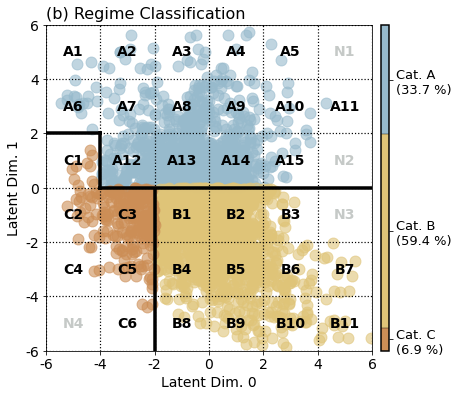

In [16]:
Plot_LS_reg(data_label='all', cat_color=True)

### Fig. S6

In [17]:
def Plot_cat_trans_ERA5(data_label:str):
    wtab_used  = eval(f'wtab_{data_label}')
    wtab_dt    = wtab_used.copy()
    wtab_dt['yyyymmdd'] = pd.to_datetime(wtab_dt['yyyymmdd'], format='%Y%m%d')
    # plot
    fig, axes = plt.subplots(2, 3, figsize=(15, 10), gridspec_kw={'wspace': 0.1, 'hspace': 0.1})
    cat_indices = extract_cat_indices(cat_bounds=sum_cat_bounds, 
                                      latent_vectors_0=wtab_dt[f'ERA5_{data_label}_lv0'].to_numpy(), 
                                      latent_vectors_1=wtab_dt[f'ERA5_{data_label}_lv1'].to_numpy())
    samp_in_cat= [v.shape[0] for v in cat_indices.values()]
    clist      = ['#97BACC', '#DFC478', '#CC8E56']
    mlist_num  = np.arange(4, 10)
    mlist_str  = ['Apr.', 'May', 'Jun.', 'Jul.', 'Aug.', 'Sep.']
    plot_idx   = np.array([0, 1, 2, 5, 4, 3])
    ax         = axes.flatten()
    for i in range(6):
        ax[plot_idx[i]].grid(linestyle=':', linewidth=1.2, color='k')
        for draw_cat in range(len(cat_indices.keys())):
            wtab_cat = wtab_dt.iloc[cat_indices[f'cat{draw_cat+1}']]
            Plot_scatter(axe=ax[plot_idx[i]], 
                     x_=wtab_cat[wtab_cat['yyyymmdd'].dt.month==mlist_num[i]][f'ERA5_{data_label}_lv0'], 
                     y_=wtab_cat[wtab_cat['yyyymmdd'].dt.month==mlist_num[i]][f'ERA5_{data_label}_lv1'], 
                     color_=clist[draw_cat], s_=120, alpha_=0.7)
        # category boundary
        draw_cat_bound(axe=ax[plot_idx[i]])
        # text: month
        ax[plot_idx[i]].text(x=-5.5, y=4.7, s=mlist_str[i], fontsize=22)
        # ticks and labels
        if plot_idx[i] != 3:
            ax[plot_idx[i]].set_xlim(-6, 6)
            ax[plot_idx[i]].set_ylim(-6, 6)
            ax[plot_idx[i]].set_xticks(np.arange(-6, 6.1, 2))
            ax[plot_idx[i]].set_yticks(np.arange(-6, 6.1, 2))
            ax[plot_idx[i]].set_xticklabels(['' for j in np.arange(-6, 6.1, 2)])
            ax[plot_idx[i]].set_yticklabels(['' for j in np.arange(-6, 6.1, 2)])
        else:
            ax[plot_idx[i]].set_xlabel('Latent Dim. 0', fontsize=16)
            ax[plot_idx[i]].set_ylabel('Latent Dim. 1', fontsize=16)
            ax[plot_idx[i]].set_xlim(-6, 6)
            ax[plot_idx[i]].set_ylim(-6, 6)
            ax[plot_idx[i]].set_xticks(np.arange(-6, 6.1, 2))
            ax[plot_idx[i]].set_yticks(np.arange(-6, 6.1, 2))
            ax[plot_idx[i]].set_xticklabels([f'{int(j)}' for j in np.arange(-6, 6.1, 2)], fontsize=16)
            ax[plot_idx[i]].set_yticklabels([f'{int(j)}' for j in np.arange(-6, 6.1, 2)], fontsize=16)
    ## Color bar
    cmap = colors.ListedColormap(clist[:len(cat_indices.keys())])
    bounds = np.array([sum(samp_in_cat[:ii])/sum(samp_in_cat)*1e2 for ii in range(len(cat_indices.keys())+1)])
    norm = colors.BoundaryNorm(bounds, cmap.N)
    cax  = fig.add_axes([ax[5].get_position().x1+0.01, ax[5].get_position().y0, 0.015, ax[2].get_position().y1-ax[5].get_position().y0])
    cbar = fig.colorbar(cm.ScalarMappable(cmap=cmap, norm=norm), 
                        cax=cax, orientation='vertical',
                        spacing='proportional', drawedges=True)
    category_name = ['A', 'B', 'C']
    cbar.set_ticks(ticks=(bounds[:-1]+bounds[1:])/2, labels=[f'Cat. {category_name[ii]}\n({ss/sum(samp_in_cat)*1e2:3.1f} %)' for ii, ss in enumerate(samp_in_cat)])
    cbar.ax.tick_params(labelsize=13)
    cbar.outline.set_linewidth(1.5)
    cbar.ax.invert_yaxis()
    plt.show()

In [18]:
Plot_cat_trans_ERA5(data_label='all')

### Fig. 4a

In [19]:
def Plot_LS_swtwpcp(data_label:str):
    wtab_used  = eval(f'wtab_{data_label}')
    swpcp_used = eval(f'swpcp_{data_label}')
    twpcp_used = eval(f'twpcp_{data_label}')
    swpcp_ratio= ((swpcp_used['accu'])/(twpcp_used['accu'])).values
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.grid(linewidth=1.2, linestyle=':', color='k')
    draw_cat_bound(ax)
    ## Scatter dots
    bounds_  = np.arange(0.35, 0.91, 0.025)
    color    = ['w', '#048DC3', '#02723E', '#DCB345', '#C27425', '#A92009']
    nodes    = np.linspace(0,1,len(color))
    cmap_    = colors.LinearSegmentedColormap.from_list("cmap", list(zip(nodes, color)))
    cmap_.set_under((0.8, 0.8, 0.8, 0.7))
    temp1    = np.argsort(swpcp_ratio)
    im       = Plot_scatter(ax, x_=wtab_used[f"ERA5_{data_label}_lv0"].iloc[temp1], y_=wtab_used[f"ERA5_{data_label}_lv1"].iloc[temp1], 
                            c_=swpcp_ratio[temp1], bounds_=bounds_, cmap_=cmap_, s_=120, alpha_=0.7, extend_='both')   # changed from s=150
    ## Regime annotation
    rcounter:int = 0
    for i in np.arange(-5, 5.1, 2):
        for j in np.arange(-5, 5.1, 2):
            if (j>=-4) & (j<2) & (i>=-4) & (i<0):
                ax.text(j, i, sum_rgime_list[rcounter], fontsize=14, fontweight='bold',
                        horizontalalignment='center', verticalalignment='center')
            rcounter+= 1
    # Colorbar
    cax          = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 0.02, ax.get_position().height])
    cbar         = fig.colorbar(im, orientation='vertical', cax=cax)
    cbar.solids.set(alpha=1)
    cbar.set_ticks(ticks=bounds_[2::4], labels=[f"{i:.1f}" for i in bounds_[2::4]])
    cbar.ax.tick_params(labelsize=13)
    cbar.outline.set_linewidth(1.5)
    # Tick ranges
    ax.set_xlim(-6, 6)
    ax.set_xticks(np.arange(-6, 6.1, 2))
    ax.set_xticklabels([f'{int(ii)}' for ii in np.arange(-6, 6.1, 2)], fontsize=14)
    ax.set_ylim(-6, 6)
    ax.set_yticks(np.arange(-6, 6.1, 2))
    ax.set_yticklabels([f'{int(ii)}' for ii in np.arange(-6, 6.1, 2)], fontsize=14)
    ax.set_xlabel('Latent Dim. 0', fontsize=14)
    ax.set_ylabel('Latent Dim. 1', fontsize=14)
    ax.set_aspect('equal', 'box')
    ax.set_title(r'(a) SW-Taiwan Preicp. Accumulative Ratio', loc='left', fontsize=16)
    plt.show()

In [20]:
Plot_LS_swtwpcp(data_label='all')

### Fig. 4b

In [21]:
def Plot_LS_swpcp(data_label:str, figtitle:str):
    wtab_used  = eval(f'wtab_{data_label}')
    swpcp_used = eval(f'swpcp_{data_label}')
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.grid(linewidth=1.2, linestyle=':', color='k')
    draw_cat_bound(ax)
    ## Scatter dots
    bounds_  = np.array([1, 2, 6, 10, 15, 20, 30, 40, 50, 70, 90, 110, 130, 150, 200, 300])
    cmap_    = cmaps.WhiteBlueGreenYellowRed.copy()
    cmap_.set_under((0.8, 0.8, 0.8, 0.7))
    temp1    = np.argsort(swpcp_used['mean'].values)
    im       = Plot_scatter(ax, x_=wtab_used[f"ERA5_{data_label}_lv0"].iloc[temp1], y_=wtab_used[f"ERA5_{data_label}_lv1"].iloc[temp1], 
                            c_=swpcp_used['mean'].iloc[temp1], bounds_=bounds_, cmap_=cmap_, s_=120, alpha_=0.75, extend_='both')   # changed from s=150
    ## Regime annotation
    rcounter:int = 0
    for i in np.arange(-5, 5.1, 2):
        for j in np.arange(-5, 5.1, 2):
            if (j>=-4) & (j<2) & (i>=-4) & (i<0):
                ax.text(j, i, sum_rgime_list[rcounter], fontsize=14, fontweight='bold',
                        horizontalalignment='center', verticalalignment='center')
            rcounter+= 1
    # Colorbar
    cax          = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 0.02, ax.get_position().height])
    cbar         = fig.colorbar(im, orientation='vertical', cax=cax)
    cbar.solids.set(alpha=1)
    cbar.set_ticks(ticks=bounds_, labels=bounds_.astype(int))
    cbar.ax.tick_params(labelsize=13)
    cbar.set_label(f'Precip. Mean (mm/day)', fontsize=13)
    cbar.outline.set_linewidth(1.5)
    # Tick ranges
    ax.set_xlim(-6, 6)
    ax.set_xticks(np.arange(-6, 6.1, 2))
    ax.set_xticklabels([f'{int(ii)}' for ii in np.arange(-6, 6.1, 2)], fontsize=14)
    ax.set_ylim(-6, 6)
    ax.set_yticks(np.arange(-6, 6.1, 2))
    ax.set_yticklabels([f'{int(ii)}' for ii in np.arange(-6, 6.1, 2)], fontsize=14)
    ax.set_xlabel('Latent Dim. 0', fontsize=14)
    ax.set_ylabel('Latent Dim. 1', fontsize=14)
    ax.set_aspect('equal', 'box')
    ax.set_title(f'{figtitle}', loc='left', fontsize=16)
    plt.show()

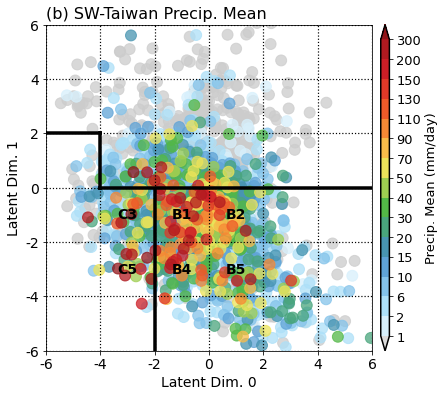

In [22]:
Plot_LS_swpcp(data_label='all', figtitle='(b) SW-Taiwan Precip. Mean')

# Figure: Large-scale IVT regimes

### Regime Processing

In [23]:
def Split_regime_date(data_label:str):
    wtab_used   = eval(f"wtab_{data_label}")
    regime_date = {}
    for j in np.arange(-5, 5.1, 2):     # z1
        for i in np.arange(-5, 5.1, 2):  # z0
            key = f"({int(i)}, {int(j)})"
            regime_date[key] = wtab_used[(wtab_used[f'ERA5_{data_label}_lv0']>=(i-1))&\
                                         (wtab_used[f'ERA5_{data_label}_lv0']<(i+1))&\
                                         (wtab_used[f'ERA5_{data_label}_lv1']>=(j-1))&\
                                         (wtab_used[f'ERA5_{data_label}_lv1']<(j+1))]['yyyymmdd'].to_list()
    return regime_date

In [24]:
regime_date_all = Split_regime_date(data_label='all')

In [27]:
regime_date_test = Split_regime_date(data_label='test')

In [28]:
def TC_pos_regime(regime_date_dict:dict, nature_string:str):
    # Load storm dict
    storm_dict = np.load(f'../../data/processed/sum_storm_dict/sum_storm_dict_{nature_string}.npy', allow_pickle=True).item()
    # Create new dict
    tcpos_dict = dict(zip(regime_date_dict.keys(), [{'lat':[], 'lon':[]} for i in range(len(list(regime_date_dict.keys())))]))  # {regime: {'lat':[], 'lon':[]}}
    tcday_dict = dict(zip(regime_date_dict.keys(), [0 for i in range(len(list(regime_date_dict.keys())))]))  # {regime: 0}
    # Loop regimes
    for kk in regime_date_dict.keys():
        ## with sample, loop dates
        if len(regime_date_dict[kk])>0:
            for dd in regime_date_dict[kk]:
                lats, lons = storm_dict[dd]['lat'], storm_dict[dd]['lon']
                tcpos_dict[kk]['lat'] = tcpos_dict[kk]['lat'] + lats
                tcpos_dict[kk]['lon'] = tcpos_dict[kk]['lon'] + lons
                lats_domfilter = np.array(lats)[(np.array(lats)>=-15)&(np.array(lats)<=30)&(np.array(lons)>=66)&(np.array(lons)<=154)]  # whether the storm is in domain
                if lats_domfilter.shape[0]>0:
                    tcday_dict[kk] += 1   # count TC days in regime
                else: pass
        else:
            pass
    return tcpos_dict, tcday_dict

In [29]:
tcpos_regime_all, tcday_regime_all = TC_pos_regime(regime_date_dict=regime_date_all, nature_string='TS')

In [30]:
def regime_comp(regime_date_dict:dict):
    # Load IVT
    mfds_ivt = xr.open_mfdataset(ERA5_IVT_files)
    # Create new dict
    ivt_comp_dict  = dict(zip(regime_date_dict.keys(), [None for i in range(len(list(regime_date_dict.keys())))]))
    ivtx_comp_dict = dict(zip(regime_date_dict.keys(), [None for i in range(len(list(regime_date_dict.keys())))]))
    ivty_comp_dict = dict(zip(regime_date_dict.keys(), [None for i in range(len(list(regime_date_dict.keys())))]))
    for kk in regime_date_dict.keys():
        date_list = regime_date_dict[kk]
        if len(date_list)>0:
            dobj_list = pd.to_datetime(date_list, format='%Y%m%d').to_numpy()  # turn date into datetime object
            temp      = mfds_ivt.sel(time=dobj_list, method='nearest').sel(lon=slice(66, 154), lat=slice(30, -15))
            ivt_comp_dict[kk]  = temp.sum_IVT_total.mean(dim='time').values
            ivtx_comp_dict[kk] = temp.sum_IVTx.mean(dim='time').values
            ivty_comp_dict[kk] = temp.sum_IVTy.mean(dim='time').values
        else: pass
    return ivt_comp_dict, ivtx_comp_dict, ivty_comp_dict

In [31]:
# ivt_comp_all, ivtx_comp_all, ivty_comp_all = regime_comp(regime_date_all)

In [32]:
# ivt_comp_test, ivtx_comp_test, ivty_comp_test = regime_comp(regime_date_test)

In [33]:
# ivt_comp_dict = {'IVT_all':ivt_comp_all, 'IVTx_all':ivtx_comp_all, 'IVTy_all':ivty_comp_all,
#                  'IVT_test': ivt_comp_test, 'IVTx_test':ivtx_comp_test, 'IVTy_test':ivty_comp_test}
# np.save('../../data/processed/demo_data/ERA5_IVT_regime_composite.npy', ivt_comp_dict)

In [34]:
ivt_comp_dict = np.load('../../data/processed/demo_data/ERA5_IVT_regime_composite.npy', allow_pickle=True).item()
ivt_comp_all, ivtx_comp_all, ivty_comp_all = ivt_comp_dict['IVT_all'], ivt_comp_dict['IVTx_all'], ivt_comp_dict['IVTy_all']
ivt_comp_test, ivtx_comp_test, ivty_comp_test = ivt_comp_dict['IVT_test'], ivt_comp_dict['IVTx_test'], ivt_comp_dict['IVTy_test']

In [35]:
def regime_comp_taiesm1(label:str):
    # Load data
    if label=='hist': 
        ds_ivt   = xr.open_dataset(TaiESM_IVT_hist)
        lv_array = lv_dict_taiesm['TaiESM1(hist)']
    elif label=='ssp585': 
        ds_ivt   = xr.open_dataset(TaiESM_IVT_ssp585)
        ds_ivt   = ds_ivt.sel(time=(ds_ivt.time.dt.year >= 2080))
        lv_array = lv_dict_taiesm['TaiESM1(ssp)'][(-21*183):, :]
    ivt_summer   = ds_ivt.sel(time=(ds_ivt.time.dt.month >= 4) & (ds_ivt.time.dt.month <= 9))
    # Composite
    ivt_comp_dict  = {}
    ivtx_comp_dict = {}
    ivty_comp_dict = {}
    for j, z1 in enumerate(np.arange(-5, 5.1, 2)):
        for i, z0 in enumerate(np.arange(-5, 5.1, 2)):
            key = f"({int(z0)}, {int(z1)})"
            cond_z0 = (lv_array[:, 0]>=(z0-1))&(lv_array[:, 0]<(z0+1))
            cond_z1 = (lv_array[:, 1]>=(z1-1))&(lv_array[:, 1]<(z1+1))
            try:
                ivt_comp_dict[key]  = ivt_summer.IVT_total.isel(time=(cond_z0&cond_z1)).mean(dim='time').values
                ivtx_comp_dict[key] = ivt_summer.IVTx.isel(time=(cond_z0&cond_z1)).mean(dim='time').values
                ivty_comp_dict[key] = ivt_summer.IVTy.isel(time=(cond_z0&cond_z1)).mean(dim='time').values
            except:
                ivt_comp_dict[key]  = np.nan
                ivtx_comp_dict[key] = np.nan
                ivty_comp_dict[key] = np.nan
    return ivt_comp_dict, ivtx_comp_dict, ivty_comp_dict

In [36]:
# ivt_comp_hist, ivtx_comp_hist, ivty_comp_hist = regime_comp_taiesm1(label='hist')

In [37]:
# ivt_comp_ssp, ivtx_comp_ssp, ivty_comp_ssp = regime_comp_taiesm1(label='ssp585')

In [38]:
# ivt_comp_dict_taiesm = {'IVT_hist':ivt_comp_hist, 'IVTx_hist':ivtx_comp_hist, 'IVTy_hist':ivty_comp_hist,
#                         'IVT_ssp': ivt_comp_ssp, 'IVTx_ssp':ivtx_comp_ssp, 'IVTy_ssp':ivty_comp_ssp}
# np.save('../../data/processed/demo_data/TaiESM_IVT_regime_composite.npy', ivt_comp_dict_taiesm)

In [39]:
ivt_comp_dict_taiesm = np.load('../../data/processed/demo_data/TaiESM_IVT_regime_composite.npy', allow_pickle=True).item()
ivt_comp_hist, ivtx_comp_hist, ivty_comp_hist = ivt_comp_dict_taiesm['IVT_hist'], ivt_comp_dict_taiesm['IVTx_hist'], ivt_comp_dict_taiesm['IVTy_hist']
ivt_comp_ssp, ivtx_comp_ssp, ivty_comp_ssp = ivt_comp_dict_taiesm['IVT_ssp'], ivt_comp_dict_taiesm['IVTx_ssp'], ivt_comp_dict_taiesm['IVTy_ssp']

### Fig. 3c (VAE-reconstruction)

In [40]:
print(recon_dict['description'])
print("-----------------------")
print(recon_dict.keys())

Print to get better readability. 
Storing reconstruction from assigned latent vectors. 
z_sample: list with tuple of (z0_j, z1_i) 
recon.: 3d-array of (sample, [2d-map])
-----------------------
dict_keys(['season', 'description', 'z_sample', 'recon.'])


In [41]:
def Plot_visLS(data_label:str):
    fig = plt.figure(figsize=(25.5, 13.5)) # changed from (27, 17)
    gs  = GridSpec(6, 6, figure=fig, wspace=0., hspace=0.)
    axes=[]
    regime_date    = eval(f"regime_date_{data_label}")
    regime_keylist = list(regime_date.keys())
    tcpos_regime   = eval(f"tcpos_regime_{data_label}")
    tcday_regime   = eval(f"tcday_regime_{data_label}")
    # Subplots
    for idx, gs_ind in enumerate(gs):
        ## Set map and grid lines
        ax  = plottools_ctpy.Axe_map(fig, gs_ind, xlim_=[65.95, 153.55], ylim_=[-15.05, 30], 
                                     xloc_=np.arange(90, 160.1, 30), yloc_=[0, 20])
        plottools_ctpy.Plot_cartopy_map(ax)
        axes.append(ax)
        ## Thicken subplot outlines
        for spine in ax.spines.values():  
            spine.set_linewidth(2)  # Adjust the thickness as needed

        ## Plot reconstructed IVT
        data_idx = ((35-idx)//6)*6+(idx%6)
        lon, lat = np.arange(66, 154.1, 1.25), np.arange(-15, 30.1, 1.25)
        recon    = recon_dict['recon.'][data_idx, ...]
        ### Two color-scale color map
        bounds   = np.arange(0, 0.81,  0.1)
        newcolors= np.vstack((cmaps.MPL_Blues(np.linspace(0., 0.7, 5)),
                              cmaps.WhiteBlue(np.linspace(0.75, 0.9, 4)),
                              ))
        cmap     = colors.ListedColormap(newcolors, name='TunedBlue')
        norm     = colors.BoundaryNorm(boundaries=bounds, ncolors=len(bounds), extend='max')
        im       = ax.contourf(lon, lat, recon, levels=np.arange(0, 0.81, 0.1), cmap=cmap, norm=norm, extend='max')

        if idx//6==5:
            ax.set_xticks([110])
            ax.set_xticklabels([f'{recon_dict["z_sample"][data_idx][0]:4.1f}'], fontsize=22)
        else:
            ax.xaxis.set_ticks([])
        if idx%6==0:
            ax.set_yticks([7.5])
            ax.set_yticklabels([f'{recon_dict["z_sample"][data_idx][1]:4.1f}'], fontsize=22)
        else:
            ax.yaxis.set_ticks([])
        ## Set regime info
        rgime_label = sum_rgime_list[data_idx]
        if rgime_label[0] == 'N':
            ax.text(x=68, y=24.5, s=fr'$\bf{{{rgime_label}}}$', fontsize=14, color=c['grey'])
        else:
            ax.text(x=68, y=24.5, s=fr'$\bf{{{rgime_label}}}$', fontsize=14, color='k')
                
    # Color bar
    cax  = fig.add_axes([axes[-1].get_position().x1+0.01,axes[-1].get_position().y0, 0.01, axes[5].get_position().y1-axes[-1].get_position().y0])
    cbar = fig.colorbar(im, ticks=np.arange(0, 0.81, 0.1), cax=cax, drawedges=True)
    cbar.outline.set_linewidth(3)
    cbar.ax.tick_params(width=2., labelsize=20)
    cbar.set_label(label='Normalized IVT Intensity', fontsize=22, labelpad=12)
    
    fig.lines.append(plt.Line2D([0.382, 0.382], [0.13, 0.503], transform=fig.transFigure, color='k', linewidth=7))     # vert. long
    fig.lines.append(plt.Line2D([0.253, 0.9], [0.503, 0.503], transform=fig.transFigure, color='k', linewidth=7))    # hori. long
    fig.lines.append(plt.Line2D([0.253, 0.253], [0.503, 0.631], transform=fig.transFigure, color='k', linewidth=7))  # vert. short
    fig.lines.append(plt.Line2D([0.126, 0.253], [0.631, 0.631], transform=fig.transFigure, color='k', linewidth=7))  # hori. short
    # xy labels
    fig.text(0.515, 0.08, 'Latent Dim. 0', ha='center', fontsize=25)
    fig.text(0.08, 0.5, 'Latent Dim. 1', va='center', fontsize=25, rotation='vertical')
    # Title
    fig.suptitle(x=0.125, y=0.89, t=f'(c) IVT Regime Representatives', fontsize=30, horizontalalignment='left', verticalalignment='bottom')
    plt.show()

In [42]:
Plot_visLS(data_label='all')

### Fig. S2, S3, S10

In [43]:
def Plot_visLScomp(data_label:str, plot_tcpos:bool=False, plot_ivt_quiver:bool=False, figtitle=False):
    fig = plt.figure(figsize=(25.5, 13.5)) # changed from (27, 17)
    gs  = GridSpec(6, 6, figure=fig, wspace=0., hspace=0.)
    axes=[]
    ivt_comp, ivtx_comp, ivty_comp = eval(f"ivt_comp_{data_label}"), eval(f"ivtx_comp_{data_label}"), eval(f"ivty_comp_{data_label}")
    regime_keylist = list(ivt_comp.keys())
    # Subplots
    for idx, gs_ind in enumerate(gs):
        ## Set map and grid lines
        ax  = plottools_ctpy.Axe_map(fig, gs_ind, xlim_=[65.95, 153.55], ylim_=[-15.05, 30], 
                                     xloc_=np.arange(90, 160.1, 30), yloc_=[0, 20])
        plottools_ctpy.Plot_cartopy_map(ax)
        axes.append(ax)
        ## Thicken subplot outlines
        for spine in ax.spines.values():  
            spine.set_linewidth(2)  # Adjust the thickness as needed

        ## Plot composite IVT
        data_idx = ((35-idx)//6)*6+(idx%6)
        if data_label in ('all', 'test'): lon, lat = np.arange(66, 154.1, 0.25), np.arange(-15, 30.1, 0.25)[::-1]
        elif data_label in ('hist', 'ssp', 'ssp585'): lon, lat = np.arange(66, 154.1, 1.25), np.arange(-15, 30.1, 1.25)
        
        cmap     = cmaps.MPL_Blues
        if isinstance(ivt_comp[regime_keylist[data_idx]], np.ndarray): # there are samples in this regime
            im       = ax.contourf(lon, lat, ivt_comp[regime_keylist[data_idx]], levels=np.arange(0, 700.1, 100), cmap=cmap, extend='max')
            ## Plot TC positions
            if plot_tcpos:
                tcpos_regime   = eval(f"tcpos_regime_{data_label}")
                tcday_regime   = eval(f"tcday_regime_{data_label}")
                y = tcpos_regime[regime_keylist[data_idx]]['lat']
                x = tcpos_regime[regime_keylist[data_idx]]['lon']
                ax.scatter(x=x, y=y, s=10, color=c['red'], marker='.')
            ## Plot IVT quivers
            if plot_ivt_quiver:
                if data_label in ('all', 'test'): 
                    ax.quiver(lon[::18], lat[::18], 
                              ivtx_comp[regime_keylist[data_idx]][::18, ::18], 
                              ivty_comp[regime_keylist[data_idx]][::18, ::18], scale=7e3, width=5e-3)
                elif data_label in ('hist', 'ssp', 'ssp585'):     
                    ax.quiver(lon[::4], lat[::4], 
                              ivtx_comp[regime_keylist[data_idx]][::4, ::4], 
                              ivty_comp[regime_keylist[data_idx]][::4, ::4], scale=7e3, width=5e-3)
        else: 
            pass
        ## Set dim. info
        if idx//6==5:
            ax.set_xticks([110])
            ax.set_xticklabels([f'{recon_dict["z_sample"][data_idx][0]:4.1f}'], fontsize=22)
        else:
            ax.xaxis.set_ticks([])
        if idx%6==0:
            ax.set_yticks([7.5])
            ax.set_yticklabels([f'{recon_dict["z_sample"][data_idx][1]:4.1f}'], fontsize=22)
        else:
            ax.yaxis.set_ticks([])
        ## Set regime info
        rgime_label = sum_rgime_list[data_idx]
        if rgime_label[0] == 'N':
            ax.text(x=68, y=24.5, s=fr'$\bf{{{rgime_label}}}$', fontsize=14, color=c['grey'])
        else:
            ax.text(x=68, y=24.5, s=fr'$\bf{{{rgime_label}}}$', fontsize=14, color='k')
                
    # Color bar
    cax  = fig.add_axes([axes[-1].get_position().x1+0.01,axes[-1].get_position().y0, 0.01, axes[5].get_position().y1-axes[-1].get_position().y0])
    cbar = fig.colorbar(im, ticks=np.arange(0, 700.1, 100), cax=cax, drawedges=True)
    cbar.outline.set_linewidth(3)
    cbar.ax.tick_params(width=2., labelsize=20)
    cbar.set_label(label='(kg/m/s)', fontsize=22, labelpad=12)
    
    fig.lines.append(plt.Line2D([0.382, 0.382], [0.13, 0.503], transform=fig.transFigure, color='k', linewidth=7))     # vert. long
    fig.lines.append(plt.Line2D([0.253, 0.9], [0.503, 0.503], transform=fig.transFigure, color='k', linewidth=7))    # hori. long
    fig.lines.append(plt.Line2D([0.253, 0.253], [0.503, 0.631], transform=fig.transFigure, color='k', linewidth=7))  # vert. short
    fig.lines.append(plt.Line2D([0.126, 0.253], [0.631, 0.631], transform=fig.transFigure, color='k', linewidth=7))  # hori. short
    # xy labels
    fig.text(0.515, 0.08, 'Latent Dim. 0', ha='center', fontsize=25)
    fig.text(0.08, 0.5, 'Latent Dim. 1', va='center', fontsize=25, rotation='vertical')
    fig.suptitle(x=0.125, y=0.89, t=f'{figtitle}', fontsize=30, horizontalalignment='left', verticalalignment='bottom')
    plt.show()

In [44]:
Plot_visLScomp(data_label='all', plot_ivt_quiver=True, figtitle='(a) ERA5 All (2001-2019)')

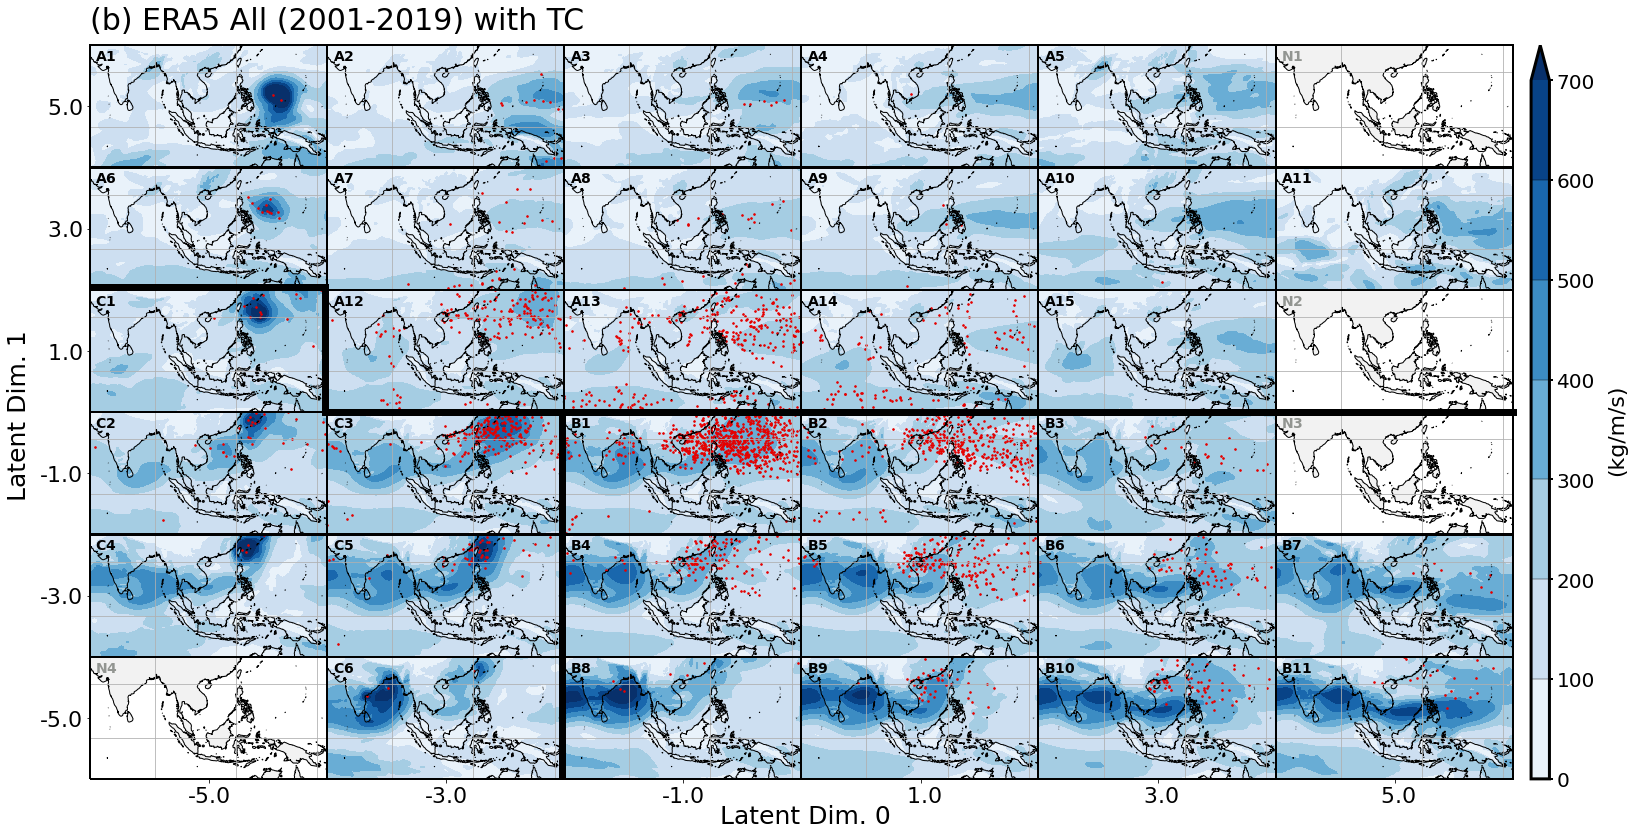

In [45]:
Plot_visLScomp(data_label='all', plot_tcpos=True, figtitle='(b) ERA5 All (2001-2019) with TC')

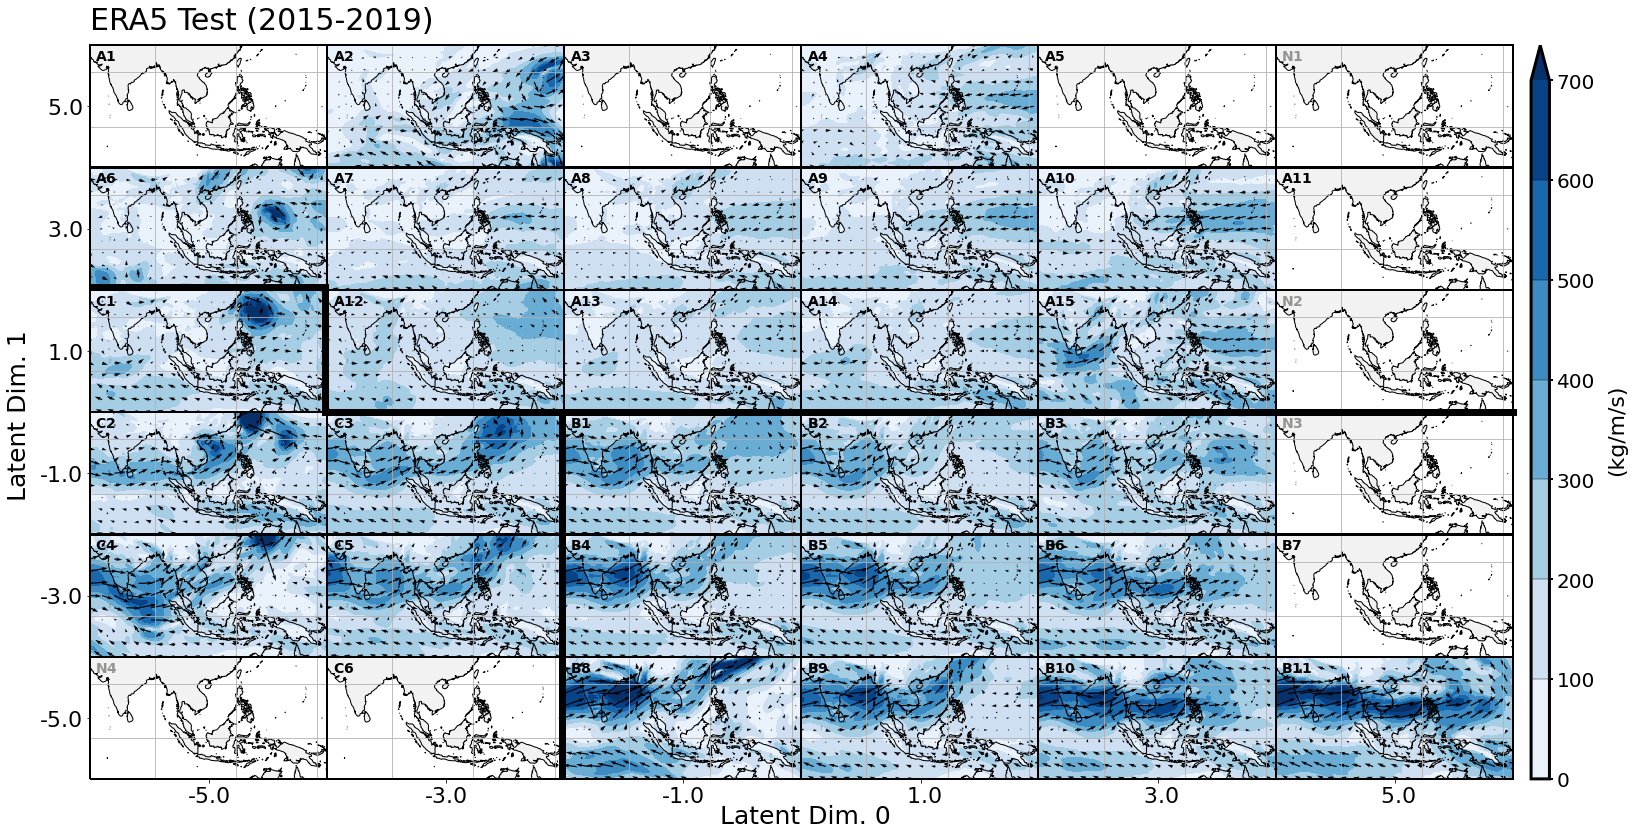

In [46]:
Plot_visLScomp(data_label='test', plot_ivt_quiver=True, figtitle='ERA5 Test (2015-2019)')

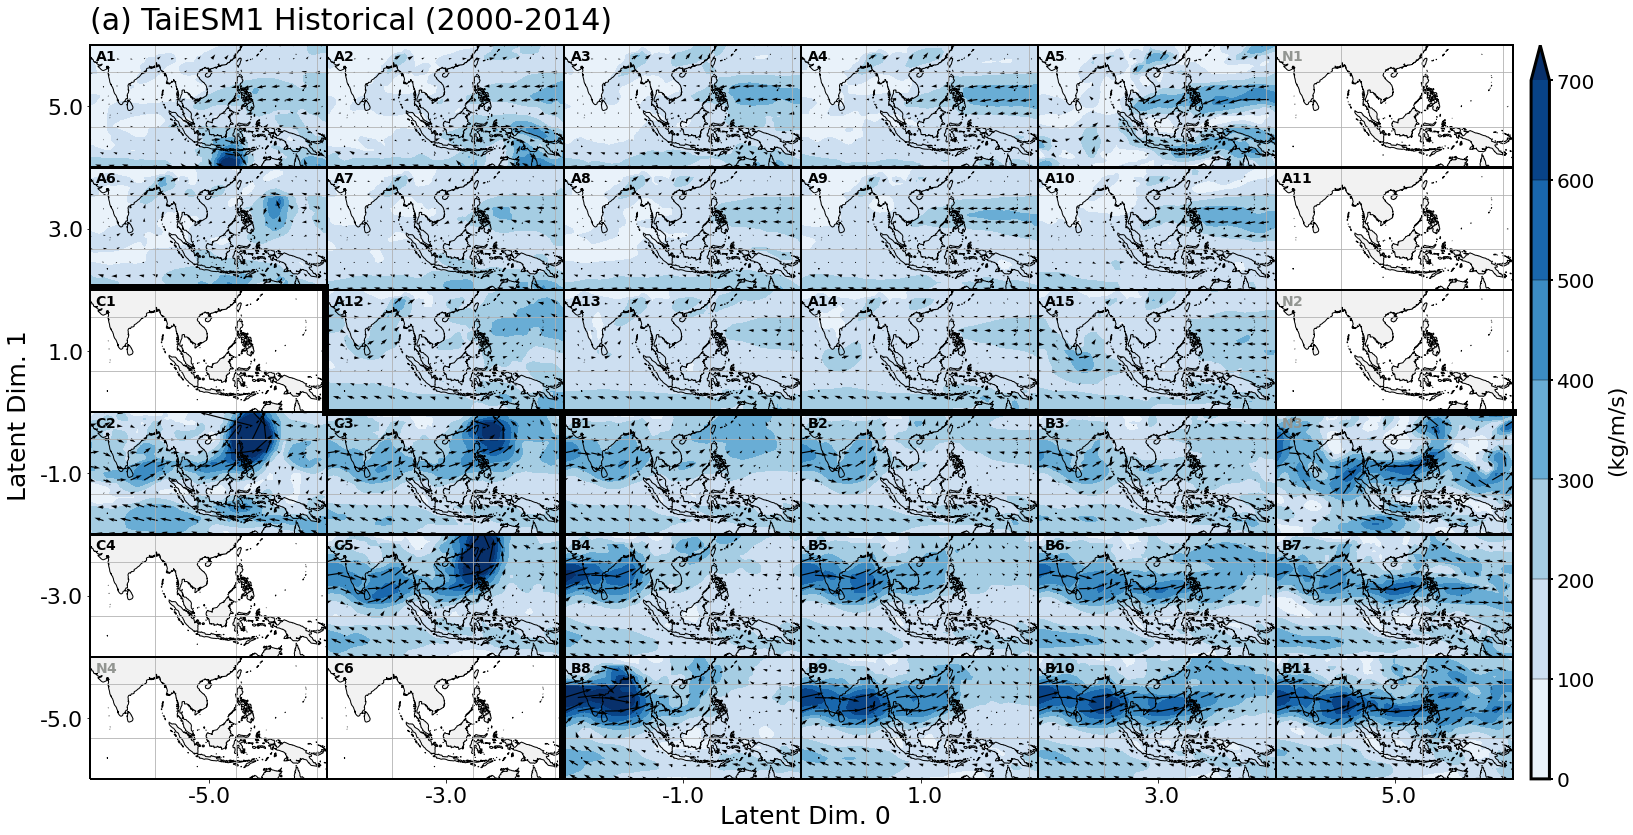

In [47]:
Plot_visLScomp(data_label='hist', plot_ivt_quiver=True, figtitle='(a) TaiESM1 Historical (2000-2014)')

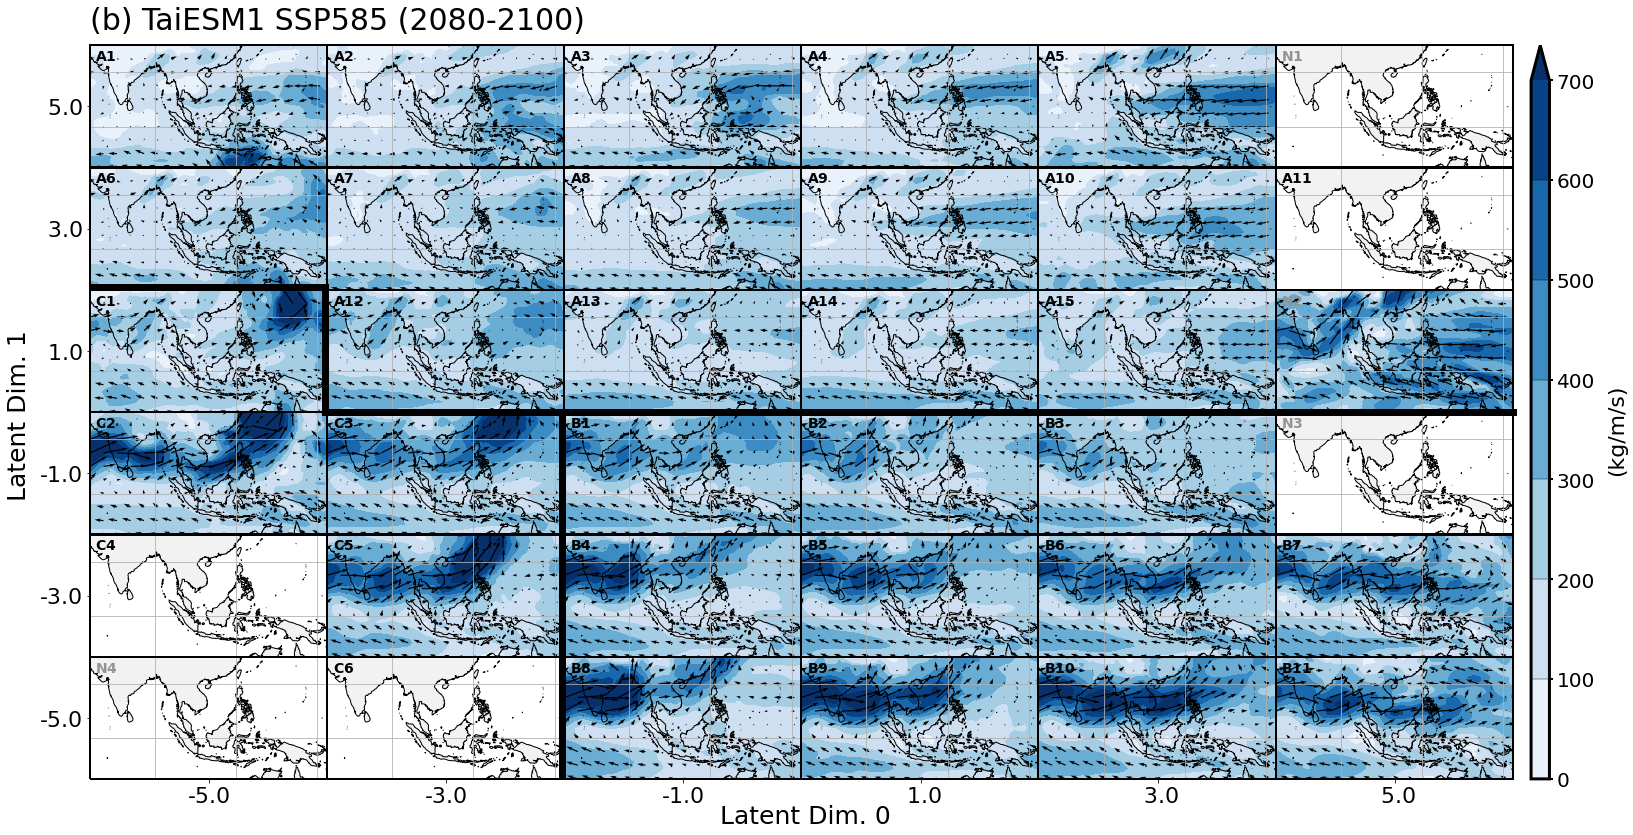

In [48]:
Plot_visLScomp(data_label='ssp', plot_ivt_quiver=True, figtitle='(b) TaiESM1 SSP585 (2080-2100)')

## Figure: Regime Frequency
Three figures: ERA5(2001-2019, 19yrs), TaiESM1-hist(2000-2014, 15yrs), TaiESM1-SSP585(2080-2100, 21yrs)

In [49]:
def Cal_regime_freq(lv_array:np.ndarray):
    regime_count = np.zeros((6, 6))
    for j, z0 in enumerate(np.arange(-5, 5.1, 2)):
        for i, z1 in enumerate(np.arange(-5, 5.1, 2)):
            cond_z0 = (lv_array[:, 0]>=(z0-1))&(lv_array[:, 0]<(z0+1))
            cond_z1 = (lv_array[:, 1]>=(z1-1))&(lv_array[:, 1]<(z1+1))
            regime_count[5-i, j] = lv_array[cond_z0&cond_z1, :].shape[0]
    regime_freq = regime_count/regime_count.sum()
    return regime_count, regime_freq

In [50]:
def Plot_regime_freq(regime_freq:np.ndarray, _type:str, figtitle:str=''):
    """
    Plot the regime frequency on the latent space with pcolor.
    :param _type: 'freq' or 'diff', the colorbar settings will be different
    """
    # Figure
    fig, ax = plt.subplots(figsize=(6, 6))
    draw_cat_bound(ax)
    ## Regime annotation
    rcounter:int = 0
    for i in np.arange(-5, 5.1, 2):
        for j in np.arange(-5, 5.1, 2):
            if sum_rgime_list[rcounter][0] == 'N':
                ax.text(j, i, sum_rgime_list[rcounter], fontsize=14, fontweight='bold',
                        horizontalalignment='center', verticalalignment='center', color=c['silver'])
            else:
                ax.text(j, i, sum_rgime_list[rcounter], fontsize=14, fontweight='bold',
                    horizontalalignment='center', verticalalignment='center')
            rcounter+= 1
    ## pcolor
    if _type == 'freq':
        bounds_  = np.asarray([0.5]+np.arange(2.5, 25.1, 2.5).tolist())*1e-2
        cmap_       = colors.ListedColormap(scicmap.lipari_r.colors[10:110])
        under_color = scicmap.oslo_r.colors[10]
        cmap_.set_under(under_color)
        tick_bounds = bounds_[::2]
        tick_labels = [f"{int(i*1e2)}" if i >=1e-2 else f"{i*1e2:.1f}" for i in tick_bounds]
        norm_ = colors.BoundaryNorm(bounds_, cmap_.N, extend='both')
    elif _type == 'diff':
        bounds_  = np.array([-7, -5, -2, -1, -0.5, 0, 0.5, 1, 2, 5, 7])*1e-2
        cmap_   = colors.ListedColormap(scicmap.vik.colors[20:])
        tick_bounds = bounds_
        tick_labels = [f"{i*1e2:4.1f}" for i in tick_bounds]
        norm_ = colors.BoundaryNorm(bounds_, cmap_.N, extend='both')
    im    = ax.pcolormesh(np.linspace(-5, 5.1, 6), np.linspace(-5, 5.1, 6), np.where(abs(regime_freq)<1e-9, np.nan, regime_freq)[::-1, :], 
                          shading='nearest', cmap=cmap_, norm=norm_, edgecolors='face')

    ## Color bar
    cax          = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 0.02, ax.get_position().height])
    cbar         = fig.colorbar(im, orientation='vertical', spacing='proportional', cax=cax)
    cbar.solids.set(alpha=1)
    cbar.set_ticks(ticks=tick_bounds, labels=tick_labels)
    cbar.ax.tick_params(labelsize=13)
    cbar.set_label(f'(%)', fontsize=13)
    cbar.outline.set_linewidth(1.5)
    
    ax.grid(linewidth=1.2, linestyle=':', color='k')
    ax.set_xlim(-6, 6)
    ax.set_xticks(np.arange(-6, 6.1, 2))
    ax.set_xticklabels([f'{int(ii)}' for ii in np.arange(-6, 6.1, 2)], fontsize=14)
    ax.set_ylim(-6, 6)
    ax.set_yticks(np.arange(-6, 6.1, 2))
    ax.set_yticklabels([f'{int(ii)}' for ii in np.arange(-6, 6.1, 2)], fontsize=14)
    ax.set_xlabel('Latent Dim. 0', fontsize=14)
    ax.set_ylabel('Latent Dim. 1', fontsize=14)
    ax.set_aspect('equal', 'box')
    ax.set_title(f'{figtitle}', loc='left', fontsize=16)
    plt.show()

In [51]:
ERA5_regime_cnt, ERA5_regime_freq = Cal_regime_freq(lv_array=lv_dict_taiesm['ERA5(whole)'])
Hist_regime_cnt, Hist_regime_freq = Cal_regime_freq(lv_array=lv_dict_taiesm['TaiESM1(hist)'])
SSP_regime_cnt,  SSP_regime_freq  = Cal_regime_freq(lv_array=lv_dict_taiesm['TaiESM1(ssp)'][-int(21*183):, :])

### Fig. 7a–c

In [52]:
Plot_regime_freq(regime_freq=ERA5_regime_freq, _type='freq', figtitle='(a) ERA5')

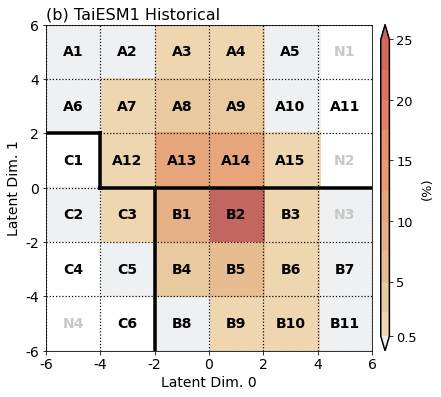

In [53]:
Plot_regime_freq(regime_freq=Hist_regime_freq, _type='freq', figtitle='(b) TaiESM1 Historical')

In [54]:
Plot_regime_freq(regime_freq=(SSP_regime_freq-Hist_regime_freq), _type='diff', figtitle='(c) TaiESM1 SSP585 - Historical')